In [24]:
import os
import glob

def get_image_types(basedir):
    return [img_type for img_type in os.listdir(basedir) if img_type != '.DS_Store']    

def get_car_images():
    basedir = 'vehicles/'
    cars = []
    for imtype in get_image_types(basedir):
        cars.extend(glob.glob(basedir + imtype+'/*'))
    return cars

def get_non_vehicle_images():
    basedir = 'non-vehicles/'
    nonvehicles = []
    for imtype in get_image_types(basedir):
        nonvehicles.extend(glob.glob(basedir + imtype+'/*'))
    return nonvehicles
    
def show_data_inspection():
    cars = get_car_images()
    nonvehicles = get_non_vehicle_images()
    
    print("Number of vehicle images:" + str(len(cars)))
    print("Number of non-vehicle images:" + str(len(nonvehicles)))
    
show_data_inspection()

Number of vehicle images:8792
Number of non-vehicle images:8968


In [27]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

In [53]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):

    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(
            cell_per_block, cell_per_block), transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
        return features, hog_image

    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
        return features
#Change transform_sqrt to False

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

def bin_spatial_QA(img, size=(32, 32)): #play to see what works best
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    
    return np.hstack(color1, color2, color3)

def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)

    hist_features = np.concatenate(
        (channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    return hist_features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True,
                    vis=False):
        img_features = []

        image = mpimg.imread(img) ###########
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, spatial_size)
            img_features.append(spatial_features)

        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            img_features.append(hist_features)

        if hog_feat == True:

            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                if vis==True:
                    hog_features, hog_image = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=True, feature_vec=True)                    
                else:
                    hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            img_features.append(hog_features) 
            
        if vis==True:
            return np.concatenate(img_features), hog_image
        else:
            return np.concatenate(img_features)
        
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []

    for img in imgs:
        img_features = single_img_features(img, color_space=color_space, spatial_size=spatial_size,
                                          hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                          cell_per_block=2, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                          hist_feat=hist_feat, hog_feat=hog_feat,vis=False)
#         img_features = []
        
#         image = mpimg.imread(img)
#         if color_space != 'RGB':
#             if color_space == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif color_space == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif color_space == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif color_space == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#             elif color_space == 'YCrCb':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#         else:
#             feature_image = np.copy(image)

#         if spatial_feat == True:
#             spatial_features = bin_spatial(feature_image, spatial_size)
#             img_features.append(spatial_features)

#         if hist_feat == True:
#             hist_features = color_hist(feature_image, nbins=hist_bins)
#             img_features.append(hist_features)

#         if hog_feat == True:

#             if hog_channel == 'ALL':
#                 hog_features = []
#                 for channel in range(feature_image.shape[2]):
#                     hog_features.append(get_hog_features(feature_image[:, :, channel],
#                                                          orient, pix_per_cell, cell_per_block,
#                                                          vis=False, feature_vec=True))
#                 hog_features = np.ravel(hog_features)
#             else:
#                 hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
#                                                 pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#             img_features.append(hog_features)
        features.append(np.concatenate(img_features))
    return features


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy



def search_windows(img, windows, clf, scaler, color_space='RGB',
                  spatial_size=(32,32), hist_bins=32,
                  hist_range=(0,256), orient=9,
                  pix_per_cell=8, cell_per_block=2,
                  hog_channel=0, spatial_feat=True,
                  hist_feat=True, hog_feat=True):
    on_windows=[]
    
    for window in windows:
        test_img = cv2.resize(img[ window[0][1]:window[1][1], window[0][0]:window[1][0] ], (64,64))
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell = pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        test_features=scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows   

def visualize(fig,rows,cols,imgs,titles):
    for i,img in enumerate(imgs):
        plt.subplot(rows,cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='gray')
            plt.title(title[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])


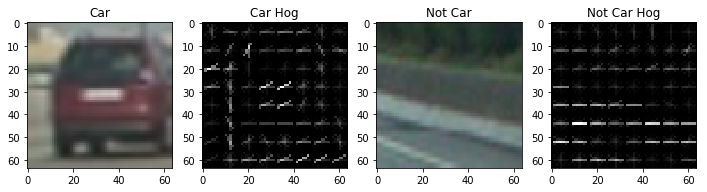

In [64]:
%matplotlib inline

cars = get_car_images()
notcars = get_non_vehicle_images()

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))


car_file = cars[car_ind]
notcar_file = notcars[notcar_ind]

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

color_space = 'RGB' #RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 #0,1,2 or 'ALL'
spatial_size=(16,16) #Spatial binning dimensions
hist_bins=16 # Number of histogram bins
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_img_features(car_file, color_space=color_space,
                                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat,hist_feat=hist_feat,
                                                 hog_feat=hog_feat,vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_file, color_space=color_space,
                                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat,hist_feat=hist_feat,
                                                 hog_feat=hog_feat,vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ["Car", "Car Hog", "Not Car", "Not Car Hog"]
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

In [35]:
# Below not in Q&A
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    count = 0
    # Normalize the image
    img = img.astype(np.float32) / 255
    img_tosearch = img[ystart:ystop, :, :]
    window_list = []
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(
            imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block**2
    # 64 is original sampling rate, with 8 cells and 8  pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Computer HOG Features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell,
                            cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell,
                            cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell,
                            cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            # Extract HOG that particular patch

            hog_feat1 = hog1[ypos:ypos + nblocks_per_window,
                             xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog1[ypos:ypos + nblocks_per_window,
                             xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog1[ypos:ypos + nblocks_per_window,
                             xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(
                ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                count = count + 1
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                # Draw as well maintain list of detected windows
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart), (xbox_left +
                                                                          win_draw, ytop_draw + win_draw + ystart), (0, 255, 0), 6)
                window_list.append(((xbox_left, ytop_draw + ystart),
                                    (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
    return window_list, draw_img


def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap


def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap


def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1] + 1):

        nonzero = (labels[0] == car_number).nonzero()

        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        bbox = ((np.min(nonzerox), np.min(nonzeroy)),
                (np.max(nonzerox), np.max(nonzeroy)))

        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)

    return img


def spot_cars(img, y_start_stops, scales, svc, X_scaler, spatial_size, hist_bins,
              orient, pix_per_cell, cell_per_block,
              hog_channel, spatial_feat, hist_feat, hog_feat):

    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    hot_windows = []
    for y_start_stop, scale in zip(y_start_stops, scales):

        img_tosearch = img[y_start_stop[0]:y_start_stop[1], :, :]
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(
                imshape[1] / scale), np.int(imshape[0] / scale)))

        ch1 = ctrans_tosearch[:, :, 0]
        ch2 = ctrans_tosearch[:, :, 1]
        ch3 = ctrans_tosearch[:, :, 2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - 1
        nfeat_per_block = orient * cell_per_block**2

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell,
                                cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell,
                                cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell,
                                cell_per_block, feature_vec=False)

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - 1
        cells_per_step = 1  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        i = 0
        for xb in range(nxsteps + 1):
            for yb in range(nysteps + 1):
                i += 1

                if xb == (nxsteps + 1):
                    xpos = ch1.shape[1] - nblocks_per_window
                else:
                    xpos = xb * cells_per_step

                if yb == (nysteps + 1):
                    ypos = ch1.shape[0] - nblocks_per_window
                else:
                    ypos = yb * cells_per_step

                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos + nblocks_per_window,
                                 xpos:xpos + nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window,
                                 xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window,
                                 xpos:xpos + nblocks_per_window].ravel()

                if hog_channel == 'ALL':
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                elif hog_channel == '0':
                    hog_features = hog_feat1
                elif hog_channel == '1':
                    hog_features = hog_feat2
                elif hog_channel == '2':
                    hog_features = hog_feat3

                xleft = xpos * pix_per_cell
                ytop = ypos * pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(
                    ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                img_features = []
                if spatial_feat:
                    img_features.append(spatial_features)
                if hist_feat:
                    img_features.append(hist_features)
                if hog_feat:
                    img_features.append(hog_features)

                img_features = np.concatenate(img_features).reshape(1, -1)

                # Scale features and make a prediction
                test_features = X_scaler.transform(img_features)
                test_prediction = svc.predict(test_features)

                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)

                if test_prediction == 1:
                    hot_windows.append(((xbox_left, ytop_draw + y_start_stop[
                                       0]), (xbox_left + win_draw, ytop_draw + win_draw + y_start_stop[0])))

        #print("scale={}, windows={}".format(scale, i))
    return hot_windows
